In [1]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import statsmodels.api as sm

from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("train.csv")

In [3]:
# Conver to DateTime object

df["date"] = pd.to_datetime(pd.to_datetime(df["OPERATIONDATE"]).dt.date)

## Aggregation

In [4]:
df = (pd.DataFrame(df.groupby(["date", "CASHPOINTID"])["AMT_SCALED"].sum())
      .reset_index()
      .rename({"CASHPOINTID": "ATM_id", "AMT_SCALED": "Amount"}, axis=1))

## Visualization

<AxesSubplot:xlabel='date', ylabel='Amount'>

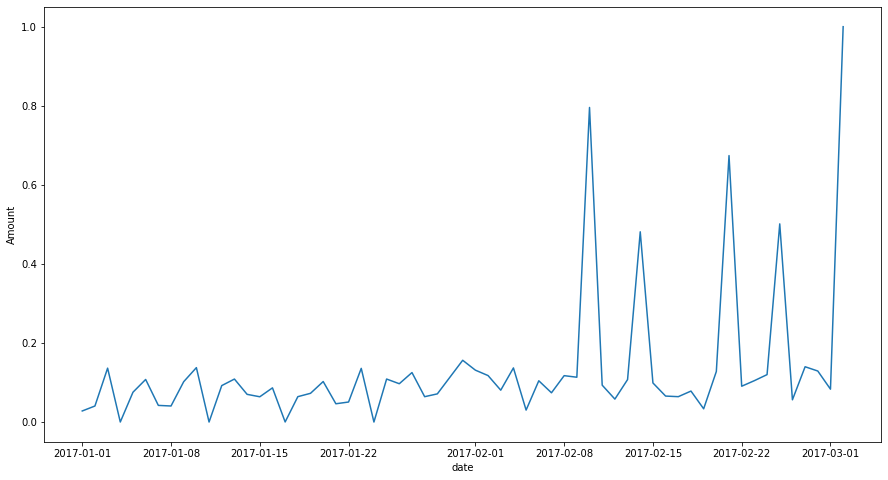

In [5]:
# Plot time series

plt.figure(figsize=(15,8))


sns.lineplot(data=df[df["ATM_id"] == 0][:60], x="date", y="Amount")

# Feature Extraction

## National Holidays

In [6]:
new_year = pd.DataFrame({'new_year' : pd.to_datetime(["2017-01-01", "2018-01-01", "2019-01-01"])})

christmas = pd.DataFrame({'christmas' : pd.to_datetime(["2017-01-07", "2018-01-07", "2019-01-07"])})

epiphany = pd.DataFrame({'epiphany' : pd.to_datetime(["2017-01-19", "2018-01-19", "2019-01-19"])})

mothers_day = pd.DataFrame({'mothers_day' : pd.to_datetime(["2017-03-03", "2018-03-03", "2019-03-03"])})

women_day = pd.DataFrame({'women_day' : pd.to_datetime(["2017-03-08", "2018-03-08", "2019-03-08"])})

easter = pd.DataFrame({'easter' : pd.to_datetime(["2017-04-16", "2018-04-08", "2019-04-28"])})

independence = pd.DataFrame({'independence' : pd.to_datetime(["2017-05-26", "2018-05-26", "2019-05-26"])})

assumption = pd.DataFrame({'assumption' : pd.to_datetime(["2017-08-28", "2018-08-28", "2019-08-28"])})

orthodox_festival = pd.DataFrame({'orthodox_festival' : pd.to_datetime(["2017-10-14", "2018-10-14", "2019-10-14"])})

george_day = pd.DataFrame({'george_day' : pd.to_datetime(["2017-11-23", "2018-11-23", "2019-11-23"])})

In [7]:
holidays = pd.concat([new_year, christmas, epiphany, mothers_day, women_day,
                      easter, independence, assumption, orthodox_festival, george_day])

### Add week days

In [8]:
df["week_days"] = df['date'].dt.day_name()

In [9]:
df["weekends"] = np.where(((df["week_days"] == "Sunday") | (df["week_days"] == "Saturday")), 1, 0)

## Add holidays

In [10]:
df["new_year"] = np.where(df["date"].isin(holidays["new_year"]), 1, 0)

df["christmas"] = np.where(df["date"].isin(holidays["christmas"]), 1, 0)

df["epiphany"] = np.where(df["date"].isin(holidays["epiphany"]), 1, 0)

df["mothers_day"] = np.where(df["date"].isin(holidays["mothers_day"]), 1, 0)

df["women_day"] = np.where(df["date"].isin(holidays["women_day"]), 1, 0)

df["easter"] = np.where(df["date"].isin(holidays["easter"]), 1, 0)

df["independence"] = np.where(df["date"].isin(holidays["independence"]), 1, 0)

df["assumption"] = np.where(df["date"].isin(holidays["assumption"]), 1, 0)

df["orthodox_festival"] = np.where(df["date"].isin(holidays["orthodox_festival"]), 1, 0)

df["george_day"] = np.where(df["date"].isin(holidays["george_day"]), 1, 0)

# Train-Test split

---

We decided to split data as a train set up to `2018-12-31` and afterward as a tests set. This leaves us with `687,122` training and `313,073` testing points

In [11]:
data = df.sort_values(by="date").copy(deep=True)

In [12]:
atm_ids = data[["date", "ATM_id"]]

In [13]:
data = data.drop(["week_days", "ATM_id"], axis=1)

In [14]:
train = data[data["date"] < "2018-12-31"]

test = data[data["date"] > "2018-12-31"]

# ARIMA

In [15]:
model = sm.tsa.statespace.SARIMAX(endog=train.iloc[:, 1].values,
                                  order=(3,1,3),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

In [16]:
res = model.fit()

In [17]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:               687122
Model:               SARIMAX(3, 1, 3)   Log Likelihood              509944.646
Date:                Thu, 17 Dec 2020   AIC                       -1019875.292
Time:                        18:00:02   BIC                       -1019795.210
Sample:                             0   HQIC                      -1019852.916
                             - 687122                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9015      0.071    -12.742      0.000      -1.040      -0.763
ar.L2         -0.7864      0.070    -11.241      0.000      -0.924      -0.649
ar.L3          0.0142      0.001     14.327      0.000       0.012       0.016
ma.L1         -0.1238      0.071     -1.751      0.080      -0.262       0.015
ma.L2         -0.1519      0.070     -2.176      0.030      -0.289      -0.015
ma.L3         -0.8331      0.073    -11.390      0.000      -0.976      -0.690
sigma2         0.0123   6.33e-06   1939.162      0.000       0.012       0.012
===================================================================================
Ljung-Box (Q):                     1026.43   Jarque-Bera (JB):        4044905227.95
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                             7.73
Prob(H) (two-sided):                  0.00   Kurtosis:                       378.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

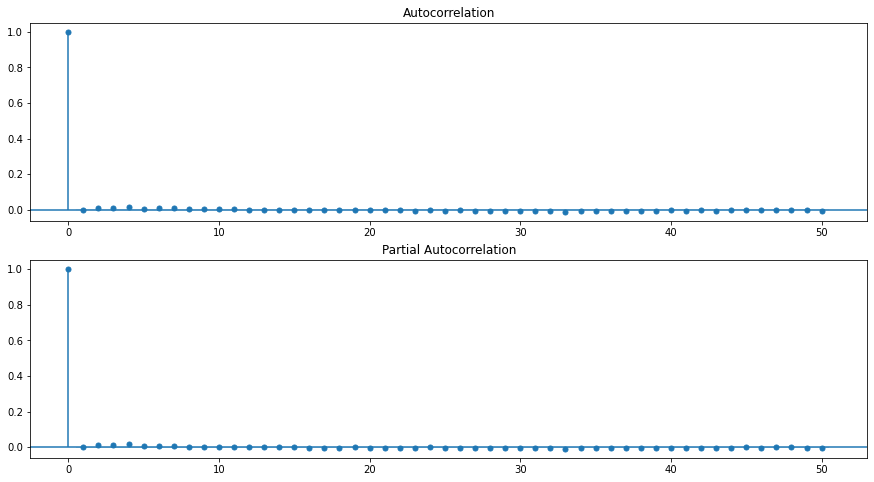

In [18]:
residuals = res.resid

fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(residuals, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(residuals, lags=50, ax=ax[1])
plt.show()

In [19]:
pred = res.predict(0, 313073)[1:]

print('ARIMAX model MSE:{}'.format(mean_squared_error(test.iloc[:, 1], pred)))

ARIMAX model MSE:0.01627549144469923


In [35]:
np.sqrt(0.01627549144469923)

0.1275754343308273

## Bar chart for the first 30 actual vs predicted values

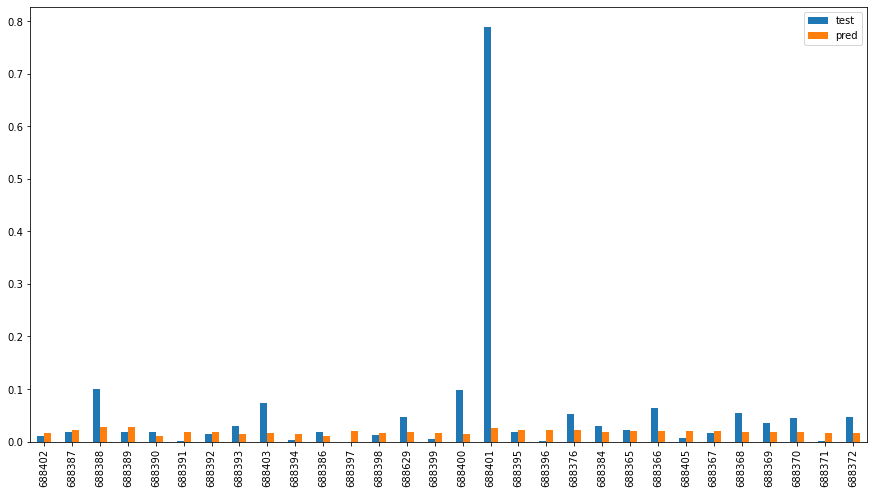

In [57]:
pd.DataFrame({'test':test.iloc[:, 1][:30],'pred':pred[:30]}).plot.bar(figsize=(15,8));plt.show()

## Plot actual vs predicted

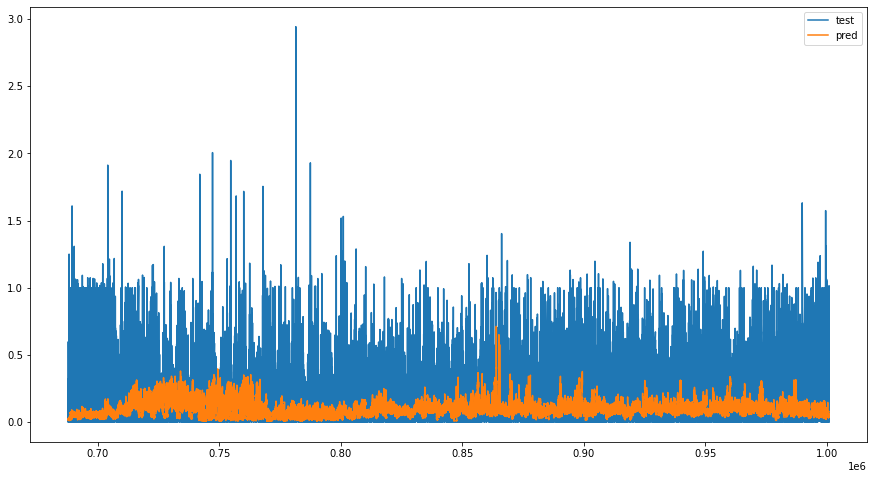

In [34]:
pd.DataFrame({'test':test.iloc[:, 1],'pred':pred}).plot(figsize=(15,8));plt.show()

## Model diagnostics plot

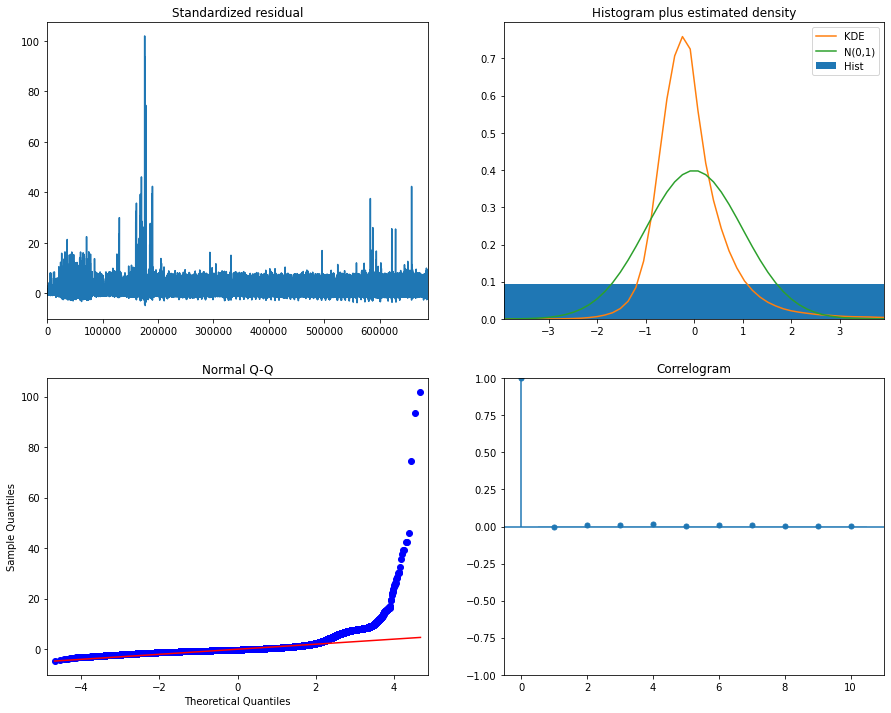

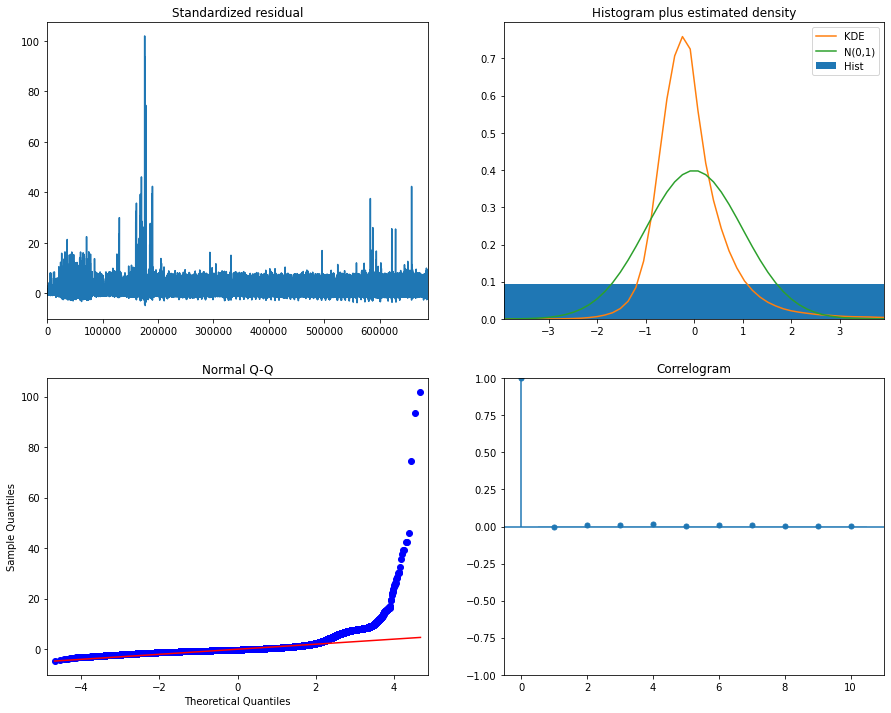

In [21]:
res.plot_diagnostics(figsize=(15, 12))

# Submission

In [43]:
submission = atm_ids[atm_ids["date"] > "2018-12-31"].copy(deep=True)

In [45]:
submission.rename({"date":"OPERATIONDATE", "ATM_id": "CASHPOINTID"}, axis=1, inplace=True)

In [46]:
submission["PREDICTION"] = pred

In [48]:
submission

,OPERATIONDATE,CASHPOINTID,PREDICTION
688402,2019-01-01,613,0.015377
688387,2019-01-01,591,0.021295
688388,2019-01-01,593,0.026942
688389,2019-01-01,595,0.027883
688390,2019-01-01,596,0.011397
...,...,...,...
1000389,2019-12-31,362,0.073466
1000390,2019-12-31,363,0.077952
1000391,2019-12-31,364,0.083245
1000365,2019-12-31,332,0.078975


In [49]:
submission.to_csv("submisson_ARIMA(3,1,3).csv", index=False)